# Programming assignment 2

Group 15: Torbjörn Livén and Samuel Kajava

## Step 1: Reading the data

We begin by downloading the data.

We read the data from the train and test datasets and set the Y values to the income (`target`), and the rest in the X values.

In [ ]:
!wget https://www.cse.chalmers.se/~richajo/dit866/data/adult_test.csv
!wget https://www.cse.chalmers.se/~richajo/dit866/data/adult_train.csv

In [4]:
import pandas as pd
# Read the CSV file.
test = pd.read_csv('adult_test.csv')
train = pd.read_csv('adult_train.csv')

cols = ["age","workclass","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","target"]
test = test[cols]
train = train[cols]
X_test = test.drop("target", axis=1)
X_train = train.drop("target", axis=1)
Y_test = test["target"]
Y_train = train["target"]

In [30]:
X_test.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States


### Step 2: Enconding the features as numbers

We now use one-hot encoding of the features to convert them to numerical values so we can work with them in scikit.

In [5]:
x_test_dict = X_test.to_dict('records')
x_train_dict = X_train.to_dict("records")
y_test_dict = Y_test.to_dict()
y_train_dict = Y_train.to_dict()

Now we encode the dicts

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
dv = DictVectorizer()
X_train_encoded = dv.fit_transform(x_train_dict)
# Y_train_encoded = dv.fit_transform(y_train_dict)

X_test_encoded = dv.transform(x_test_dict)
# Y_test_encoded = dv.transform(y_test_dict)
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

Then we train a GradientBoostingClassifier

In [7]:
import sklearn.ensemble as ensemble
from sklearn.model_selection import cross_val_score
import numpy as np

gb_clf = ensemble.GradientBoostingClassifier(max_depth=10)
gb_cross_val = cross_val_score(gb_clf, X_train_encoded, Y_train_encoded)
print(np.mean(gb_cross_val))

0.8711036064329478


### Step 3: Combining the steps

Now it is time to do some more preprocessing, and we make a pipeline consisting of our vectorization followed by a RandomForestClassifier.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
  DictVectorizer(),
  DecisionTreeClassifier ()
)

pipeline.fit(x_train_dict, Y_train_encoded)

Pipeline(steps=[('dictvectorizer', DictVectorizer()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, x_test_dict, Y_test_encoded, cv=5)
print("Cross-validation scores:", scores)
print("Average score:", np.mean(scores))

Cross-validation scores: [0.81363218 0.81296069 0.80712531 0.80589681 0.82340295]
Average score: 0.8126035852471223


## Task 2: Decision trees and random forests

We now investigate the performance of classifiers with regards to the maxmimum depth of the tree.

We test for depths `1..12` with a pipeline using a `DecisionTreeClassifier`.

In [27]:
from sklearn.tree import DecisionTreeClassifier

total_scores = []
for estimators in range(1, 12):
  pipeline = make_pipeline(
    DictVectorizer(),
    DecisionTreeClassifier(max_depth=estimators)
  )
  pipeline.fit(x_train_dict, Y_train_encoded)
  scores = cross_val_score(pipeline, x_test_dict, Y_test_encoded, cv=5)
  total_scores.append({"scores": scores, "avg_score": np.mean(scores)})


print(total_scores)

[{'scores': array([0.76358612, 0.76382064, 0.76382064, 0.76382064, 0.76382064]), 'avg_score': 0.7637737354961794}, {'scores': array([0.82929076, 0.82923833, 0.8264742 , 0.83722359, 0.83722359]), 'avg_score': 0.8318900927052602}, {'scores': array([0.84464231, 0.84183047, 0.83814496, 0.84858722, 0.8507371 ]), 'avg_score': 0.8447884126345901}, {'scores': array([0.84433528, 0.84183047, 0.83875921, 0.84920147, 0.85104423]), 'avg_score': 0.8450341317396889}, {'scores': array([0.84863371, 0.84797297, 0.85012285, 0.85810811, 0.85687961]), 'avg_score': 0.8523434500176903}, {'scores': array([0.85078293, 0.85503686, 0.84981572, 0.85933661, 0.85964373]), 'avg_score': 0.854923170581752}, {'scores': array([0.85723058, 0.85350123, 0.85104423, 0.86025799, 0.86179361]), 'avg_score': 0.8567655263771321}, {'scores': array([0.85630949, 0.85135135, 0.8507371 , 0.86302211, 0.85964373]), 'avg_score': 0.8562127574025025}, {'scores': array([0.85569543, 0.85810811, 0.84889435, 0.85841523, 0.85534398]), 'avg_sco

We see that it keeps increasing in performance until around max_depth=6/7, then it probably overfits on the training data and it performs worse on the test set.

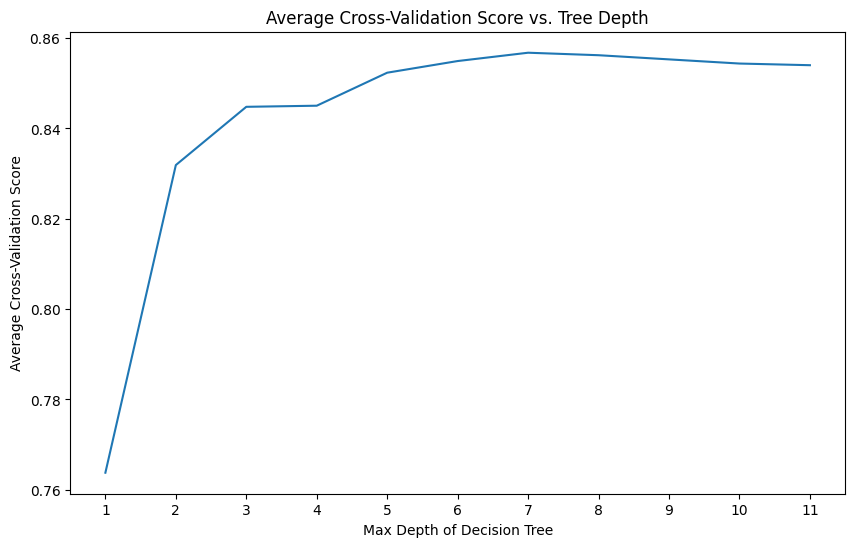

In [29]:
import matplotlib.pyplot as plt
# Extracting average scores and depths
avg_scores = [d['avg_score'] for d in total_scores]
depths = range(1, len(avg_scores) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(depths, avg_scores)
plt.title("Average Cross-Validation Score vs. Tree Depth")
plt.xlabel("Max Depth of Decision Tree")
plt.ylabel("Average Cross-Validation Score")
plt.xticks(depths)
plt.show()

### Underfitting and overfitting in random forest classifiers

We now will perform the same experiment as the one above, but look at a `RandomForestClassifier` with regards to the size of the ensemble, i.e., the `n_estimators` parameter

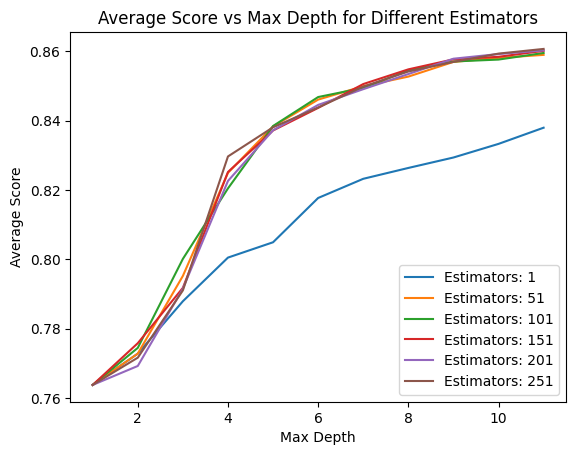

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
total_scores = []

for estimators in range(1, 301, 50):
    avg_scores = []
    depths = []
    for depth in range(1, 12):
        pipeline = make_pipeline(
            DictVectorizer(),
            RandomForestClassifier(n_estimators=estimators, max_depth=depth, n_jobs=-1)
        )
        pipeline.fit(x_train_dict, Y_train_encoded)
        scores = cross_val_score(pipeline, x_test_dict, Y_test_encoded, cv=5)
        avg_scores.append(np.mean(scores))
        depths.append(depth)
    total_scores.append({"estimators": estimators, "depths": depths, "avg_scores": avg_scores})

for score_data in total_scores:
    plt.plot(score_data["depths"], score_data["avg_scores"], label=f"Estimators: {score_data['estimators']}")

plt.xlabel("Max Depth")
plt.ylabel("Average Score")
plt.title("Average Score vs Max Depth for Different Estimators")
plt.legend()
plt.show()

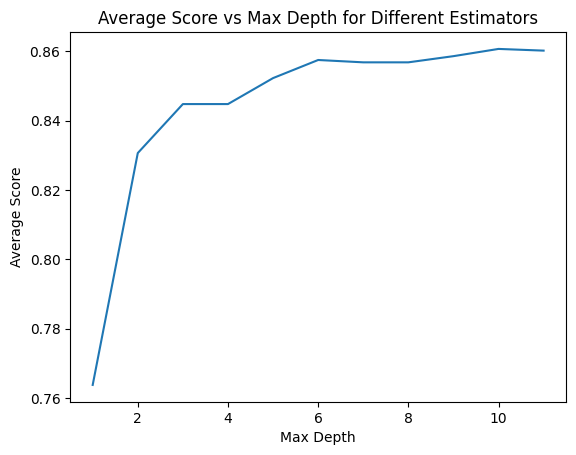

In [25]:
depth_scores = []
for depth in range(1,12):
  clf = DecisionTreeClassifier(max_depth=depth)
  clf.fit(X_train_encoded, Y_train_encoded)
  depth_scores.append(clf.score(X_test_encoded, Y_test_encoded))

plt.plot(range(1,12), depth_scores)
plt.xlabel("Max Depth")
plt.ylabel("Average Score")
plt.title("Average Score vs Max Depth for Different Estimators")
plt.show()

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.feature_extraction import DictVectorizer

pipeline = make_pipeline(
    DictVectorizer(),
    RandomForestClassifier(n_estimators=1, n_jobs=-1)
)
pipeline.fit(x_train_dict, Y_train_encoded)
pipeline_score = cross_val_score(pipeline, x_test_dict, Y_test_encoded, cv=5)
print("Random Forest score: ", np.mean(pipeline_score))

clf = DecisionTreeClassifier()
clf.fit(X_train_encoded, Y_train_encoded)
dtree_score = cross_val_score(clf, X_test_encoded, Y_test_encoded, cv=5)
print("Decision Tree score: ", np.mean(dtree_score))

Random Forest score:  0.799644066569151
Decision Tree score:  0.8135249800278969


What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?

The decision tree is trained on all the data and features while the RandomForest with an ensemble of size 1 also only has one DecisionTree, that DecisionTree is only trained on a subset of the data and features. This scenario introduces an advantage to the DecisionTree, as it gets to train on a larger dataset, while the RandomForest needs an esemble to produce viable results. If the ensemble is small, it gets no opportunity to improve the model between runs, which is bad since that is the main point of using ensemble models.


What happens with the curve for random forests as the ensemble size grows?
As the ensemble size grows, the curve goes towards a more stable value that it hovers around for all ensemble sizes. 

What happens with the best observed test set accuracy as the ensemble size grows?
It stays the same, as the ensemble size grows, it does not really get better with a larger ensemble size. There is a large difference between a size of 1 and 50 but between 50 and 300, there is not really any difference. 


What happens with the training time as the ensemble size grows? The training time increases linearly as the the ensemble size grows.

## Task 3

We extract the features and sort them descendingly. 

The most important features seem to be pretty obvious such as age, hours worked per week, capital gain and education. Something interesting though is that a feature such as the workclass never-worked isn't rated as a feature of high importance, because if someone never worked then they probably don't make over 50K a year. But looking at the dataset it only occurred in 7 cases, which probably is not enough to make an impact. 

Perr et al. (2018) mentions permutation importance as a reliable way to get better and more realistic feature importance values. By removing a feature and see how much the accuracy of the model is changed compared to a baseline, we get a good feel for how important a feature is for predicting a correct result without introducing bias. 

In [41]:
dict_vectorizer = pipeline.steps[0][1]
features_names = dict_vectorizer.feature_names_

clf = pipeline.steps[1][1]
feature_importance = clf.feature_importances_

features = list(zip(features_names, feature_importance))
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

for feature in sorted_features:
  print(feature)

('age', 0.22650482335372668)
('hours-per-week', 0.11405905427690158)
('capital-gain', 0.10741326458724008)
('education-num', 0.0679170161418503)
('marital-status=Married-civ-spouse', 0.06431271127986277)
('relationship=Husband', 0.04236598787199315)
('capital-loss', 0.03553908447317525)
('marital-status=Never-married', 0.027952251964743116)
('occupation=Exec-managerial', 0.0192584997053966)
('occupation=Prof-specialty', 0.015456843855704125)
('relationship=Not-in-family', 0.012571910334762619)
('education=Bachelors', 0.012187495326396939)
('workclass=Private', 0.0114032721696194)
('relationship=Wife', 0.010899317538153772)
('relationship=Own-child', 0.009942112381965266)
('sex=Female', 0.009501746577066688)
('sex=Male', 0.009277167656400152)
('workclass=Self-emp-not-inc', 0.009243728259439902)
('education=HS-grad', 0.008177275848428407)
('education=Masters', 0.008168826576437744)
('occupation=Other-service', 0.0074759346999885125)
('occupation=Sales', 0.007294930212582272)
('occupation